In [1]:
import numpy as np
import dask , dask.distributed
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import cmocean.cm as cmo
import warnings
warnings.simplefilter('ignore')
import dask_jobqueue
from astropy.convolution import Box2DKernel, convolve
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
import matplotlib.colors as colors
import pandas as pd
from fix_grid import fix_grid 

from scipy.ndimage import generic_filter

In [2]:
def Data_3D_median(data, time='time'):
    #filters for every time step, need to specify time --> 'month', 'time'
    res=[]
    for date in data[time]:
        conv=median_filter(data.sel(time=date), size=30)
        res.append(conv)
    da_res=xr.concat(res, dim=time)
    return da_res
   

def median_filter(data, size=30):
    filtered_data = generic_filter(data, np.nanmedian, size=size, mode="wrap")
    filtered_data=data.copy(data=filtered_data)
    return filtered_data

In [4]:
ds_original=xr.open_dataset('/gxfs_work/geomar/smomw577/mesoscale_eddies/MOM5_concat/0181-0190/MOM5_control_monthly_0181-0190_noice_all.nc')

In [5]:
import time

start_time = time.time()

testvar_co2=ds_original.dic_stf.isel(time=2)
res_co2=median_filter(testvar_co2)
testano_co2=testvar_co2-res_co2
testvar_co2=fix_grid(testvar_co2)
res_co2=fix_grid(res_co2)
testano_co2=fix_grid(testano_co2)
res_co2=res_co2.where(~np.isnan(testvar_co2))

end_time = time.time()  # End time

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

Execution time: 231.541343 seconds


In [6]:
ds_original

<xarray.Dataset>
Dimensions:    (time: 120, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time       (time) object 0181-01-16 12:00:00 ... 0190-12-16 12:00:00
    geolon_t   (yt_ocean, xt_ocean) float32 ...
    geolat_t   (yt_ocean, xt_ocean) float32 ...
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    st_ocean   float64 ...
Data variables:
    o2_stf     (time, yt_ocean, xt_ocean) float32 ...
    dic_stf    (time, yt_ocean, xt_ocean) float32 ...
    SSH        (time, yt_ocean, xt_ocean) float32 ...
    SST        (time, yt_ocean, xt_ocean) float32 ...
    sens_heat  (time, yt_ocean, xt_ocean) float32 ...
    evap_heat  (time, yt_ocean, xt_ocean) float32 ...
    mld        (time, yt_ocean, xt_ocean) float32 ...
    jp_all     (time, yt_ocean, xt_ocean) float64 ...
Attributes:
    CDI:          Climate Data Interface version 2.4.2 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    filename:     01810101.ocean_minibling_term_src.nc
    title:        CM2.6_miniBling
    grid_type:    mosaic
    grid_tile:    1
    history:      Fri Mar 07 16:25:32 2025: cdo merge MOM5_control_monthly_no...
    CDO:          Climate Data Operators version 2.4.2 (https://mpimet.mpg.de...

In [8]:
####CO2

testvar_co2=ds_original.dic_stf.isel(time=2)
res_co2=median_filter(testvar_co2)
testano_co2=testvar_co2-res_co2
testvar_co2=fix_grid(testvar_co2)
res_co2=fix_grid(res_co2)
testano_co2=fix_grid(testano_co2)
res_co2=res_co2.where(~np.isnan(testvar_co2))

####O2
testvar_o2=ds_original.o2_stf.isel(time=2)
res_o2=median_filter(testvar_o2)
testano_o2=testvar_o2-res_o2
testvar_o2=fix_grid(testvar_o2)
res_o2=fix_grid(res_o2)
testano_o2=fix_grid(testano_o2)
res_o2=res_o2.where(~np.isnan(testvar_o2))

## SST
testvar_sst=ds_original.SST.isel(time=2)
res_sst=median_filter(testvar_sst)
testano_sst=testvar_sst-res_sst
res_sst=res_sst.where(~np.isnan(testvar_sst))

testvar_sst=fix_grid(testvar_sst)
res_sst=fix_grid(res_sst)
testano_sst=fix_grid(testano_sst)

## sens heat
testvar_sh=ds_original.sens_heat.isel(time=2)
res_sh=median_filter(testvar_sh)
testano_sh=testvar_sh-res_sh
res_sh=res_sh.where(~np.isnan(testvar_sh))

testvar_sh=fix_grid(testvar_sh)
res_sh=fix_grid(res_sh)
testano_sh=fix_grid(testano_sh)


##latent heat
testvar_lh=ds_original.evap_heat.isel(time=2)
res_lh=median_filter(testvar_lh)
testano_lh=testvar_lh-res_lh
res_lh=res_lh.where(~np.isnan(testvar_lh))

testvar_lh=fix_grid(testvar_lh)
res_lh=fix_grid(res_lh)
testano_lh=fix_grid(testano_lh)

# make maps

In [9]:
def map_mapping(data, figname, vminabs, vmaxabs, vminano, vmaxano, label):

    fig, axs= plt.subplots(nrows=3, ncols=1 , figsize=(9,9.5),subplot_kw={'projection': ccrs.PlateCarree()})


    data[0].sel(xt_ocean=slice(0,50) ,yt_ocean=slice(-47.5,-30)).plot(ax=axs[0], vmin=vminabs,vmax=vmaxabs,cmap=cmo.thermal, transform = ccrs.PlateCarree(),cbar_kwargs={'label': label}, y='geolat_t', x='geolon_t')
    data[1].sel(xt_ocean=slice(0,50),  yt_ocean=slice(-47.5,-30)).plot(ax=axs[1], vmin=vminabs,vmax=vmaxabs,cmap=cmo.thermal, transform = ccrs.PlateCarree(),cbar_kwargs={'label': label}, y='geolat_t', x='geolon_t')
    data[2].sel(xt_ocean=slice(0,50), yt_ocean=slice(-47.5,-30)).plot(ax=axs[2], cmap=cmo.balance, vmin=vminano, vmax=vmaxano, transform = ccrs.PlateCarree(),cbar_kwargs={'label': label}, y='geolat_t', x='geolon_t')
    
    
    for ax in axs:
        #ax.set_extent([0, 50, -47.5, -30])
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1, color='black', alpha=0.2)
    #axs.add_feature(ccrs.cartopy.feature.COASTLINE)
        gl.xlabels_top = False
        gl.ylabels_left = True
        gl.ylabels_right = False
        gl.xlabel_style = {'size': 14}
        gl.ylabel_style = {'size': 14}
        ax.coastlines()
    axs[0].set_title('original', fontweight='bold', fontsize=15)
    axs[1].set_title('smoothed', fontweight='bold', fontsize=15)
    axs[2].set_title('anomaly', fontweight='bold', fontsize=15)
    plt.savefig('/gxfs_home/geomar/smomw577/plots/Boxcar/0181-0190/'+figname, dpi=300, bbox_inches='tight')

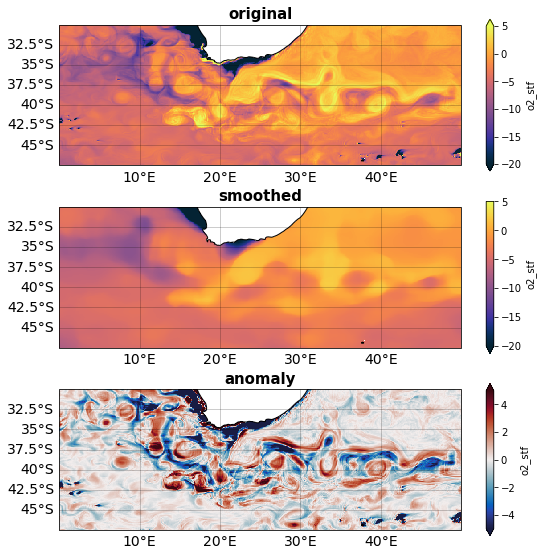

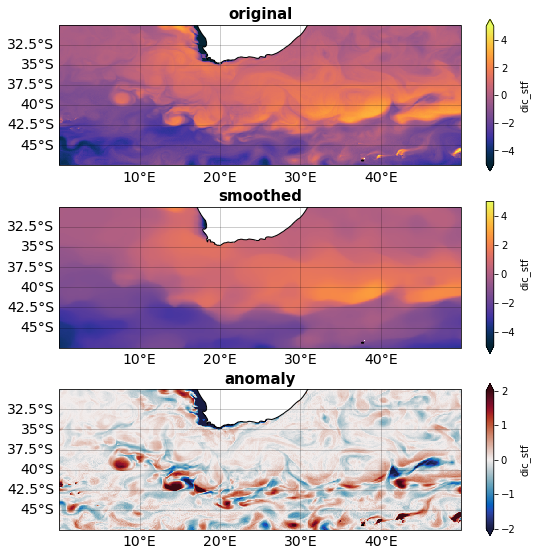

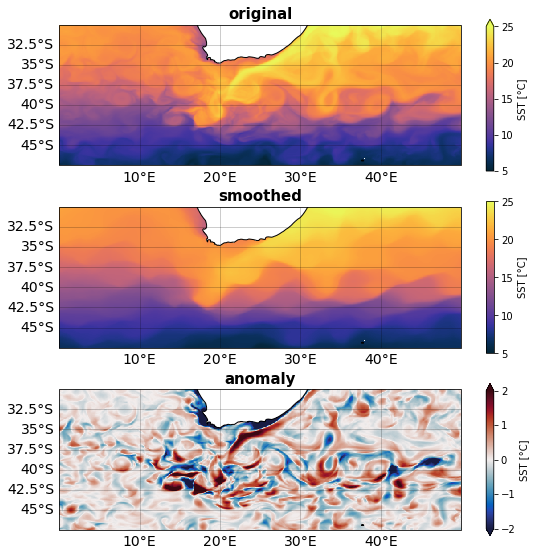

In [10]:
map_mapping([testvar_o2, res_o2, testano_o2], 'test_medianfilter_o2.png', -20, 5, -5, 5, 'o2_stf')
map_mapping([testvar_co2, res_co2, testano_co2], 'test_medianfilter_co2.png', -5, 5, -2, 2, 'dic_stf')
map_mapping([testvar_sst, res_sst, testano_sst], 'test_medianfilter_SST.png', 5, 25, -2, 2, 'SST [°C]')

In [ ]:
#map_mapping([testvar_sh, res_sh, testano_sh], 'test_medianfilter_sh.png', 5, 25, -2, 2, 'sens_heat')
#map_mapping([testvar_lh, res_lh, testano_lh], 'test_medianfilter_lh.png', 5, 25, -2, 2, 'evap_heat')

## compare to mean filter

In [4]:
pathf='/gxfs_work/geomar/smomw577/mesoscale_eddies/BOX_filtered/0181-0190/'

In [5]:
ds_smoothed=xr.open_dataset(pathf+'3x3box_monthly_0181-0190.nc')
ds_smoothed=fix_grid(ds_smoothed)
dsa=xr.open_dataset(pathf+'3x3box_anomaly_monthly_0181-0190.nc')
dsa=fix_grid(dsa)
ds_original=fix_grid(ds_original)

In [13]:
ds_agulhas=ds_original.isel(time=2).sel(xt_ocean=slice(0,50), yt_ocean=slice(-47.5,-30))
ds_agulhas_ano=dsa.isel(time=2).sel(xt_ocean=slice(0,50), yt_ocean=slice(-47.5,-30))
ds_agulhas_smoothed=ds_smoothed.isel(time=2).sel(xt_ocean=slice(0,50), yt_ocean=slice(-47.5,-30))
ds_agulhas_smoothed=ds_agulhas_smoothed.where(ds_agulhas_ano.notnull())

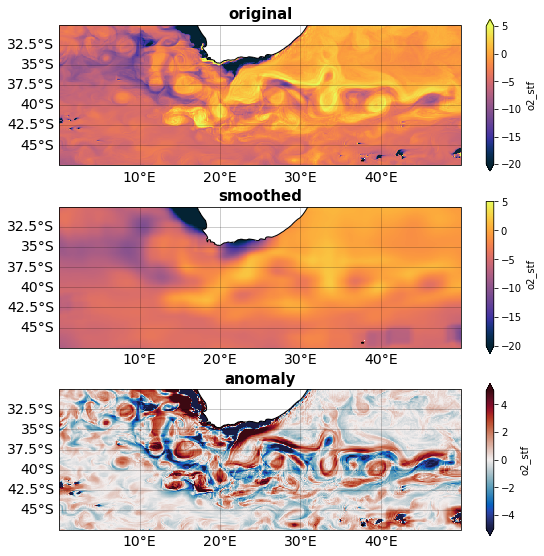

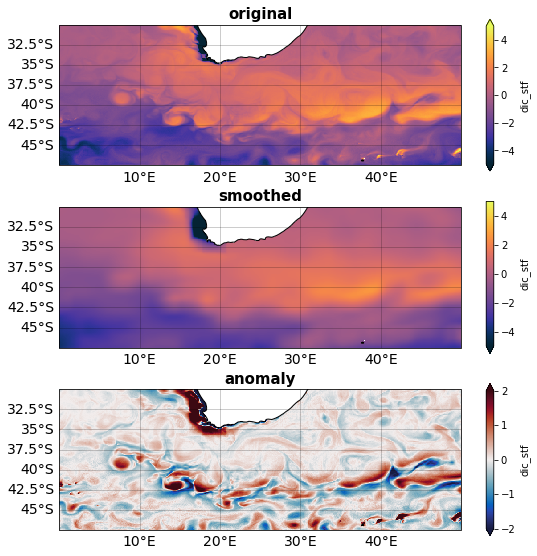

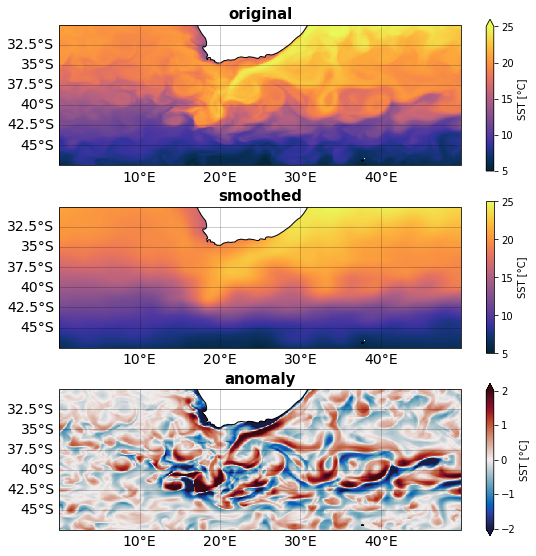

In [14]:
map_mapping([ds_agulhas.o2_stf, ds_agulhas_smoothed.o2_stf, ds_agulhas_ano.o2_stf], 'test_meanfilter_o2.png', -20, 5, -5, 5, 'o2_stf')
map_mapping([ds_agulhas.dic_stf, ds_agulhas_smoothed.dic_stf, ds_agulhas_ano.dic_stf], 'test_meanfilter_co2.png', -5, 5, -2, 2, 'dic_stf')
map_mapping([ds_agulhas.SST, ds_agulhas_smoothed.SST, ds_agulhas_ano.SST], 'test_meanfilter_SST.png', 5, 25, -2, 2, 'SST [°C]')

# Make histogram

In [17]:
def histo_3x3(data, name, plotname, limits):
    box3x3=data[0].sel(xt_ocean=slice(15,18), yt_ocean=slice(-38,-35))
    box3x3s=data[1].sel(xt_ocean=slice(15,18), yt_ocean=slice(-38,-35))
    box3x3a=data[2].sel(xt_ocean=slice(15,18), yt_ocean=slice(-38,-35))
    
    box3x3_mean=box3x3.mean()
    box3x3a_mean=box3x3a.mean()
    box3x3s_mean=box3x3s.mean()
    
    
    box3x3_median=box3x3.median(skipna=True)
    box3x3s_median=box3x3s.median(skipna=True)
    box3x3a_median=np.nanmedian(box3x3a.compute())
    
    fig, axs= plt.subplots(nrows=3, ncols=1, figsize=(8,12))
    axs=axs.flatten()
    ### median und mean
    box3x3.plot.hist(ax=axs[0], bins=80, color='pink',alpha=.6, edgecolor='red', density=True);
    box3x3s.plot.hist(ax=axs[1], bins=80, color='pink',alpha=.6, edgecolor='red', density=True);    
    box3x3a.plot.hist(ax=axs[2], bins=80, color='pink',alpha=.6, edgecolor='red', density=True);

    axs[0].set_title('Total '+name   , fontweight='bold')
    axs[0].axvline(box3x3_mean, c='black')
    axs[0].axvline(box3x3_median, c='green')
    axs[1].axvline(box3x3s_median, c='green')
    axs[1].axvline(box3x3s_mean, c='black')
    axs[1].set_title('Smoothed '+name     , fontweight='bold')  
    axs[2].axvline(box3x3a_median, c='green')
    axs[2].axvline(box3x3a_mean, c='black')
    axs[2].set_title('Anomalies '+name, fontweight='bold')
    
    for ax in axs:
        ax.grid(color='darkgray', linestyle='dotted')
        ax.set_xlabel('')
    for i in [0,1]:
        axs[i].set_xlim(limits)
    
    plt.savefig('/gxfs_home/geomar/smomw577/plots/Boxcar/0181-0190/'+plotname, dpi=300, bbox_inches='tight');


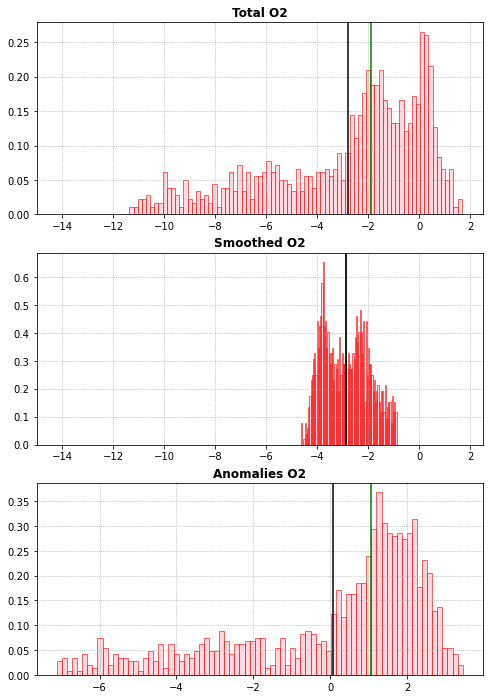

In [25]:
histo_3x3([ds_agulhas.o2_stf, ds_agulhas_smoothed.o2_stf, ds_agulhas_ano.o2_stf], 'O2', 'meanfilter_o2_pdf.png', [-15,2.5])

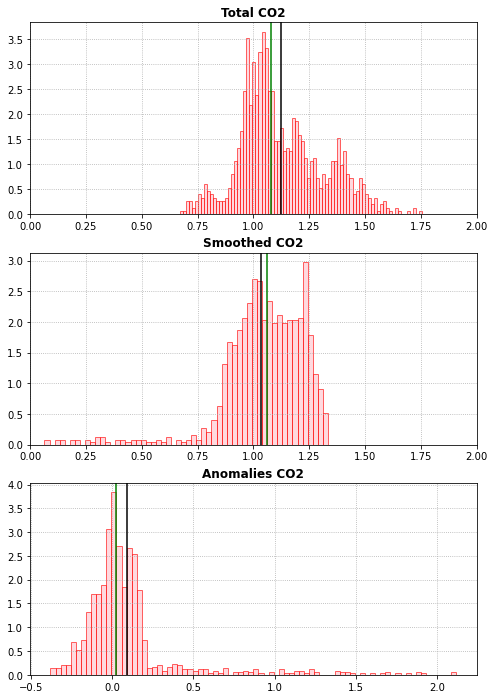

In [27]:
histo_3x3([ds_agulhas.dic_stf, ds_agulhas_smoothed.dic_stf, ds_agulhas_ano.dic_stf], 'CO2', 'meanfilter_co2_pdf.png', [0,2])

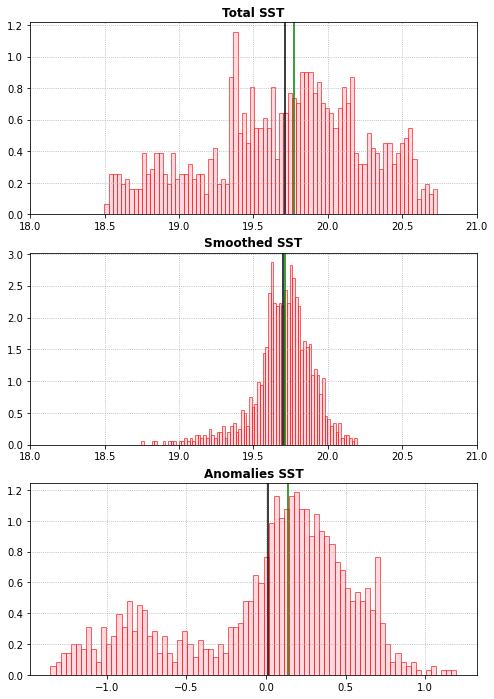

In [31]:
histo_3x3([ds_agulhas.SST, ds_agulhas_smoothed.SST, ds_agulhas_ano.SST], 'SST', 'meanfilter_sst_pdf.png', [18,21])

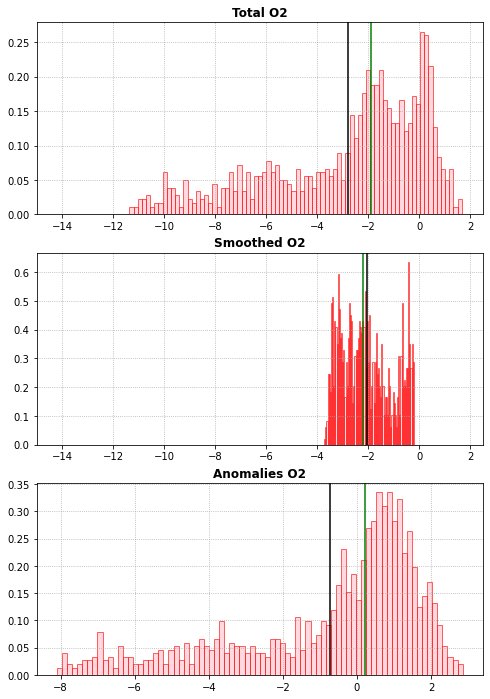

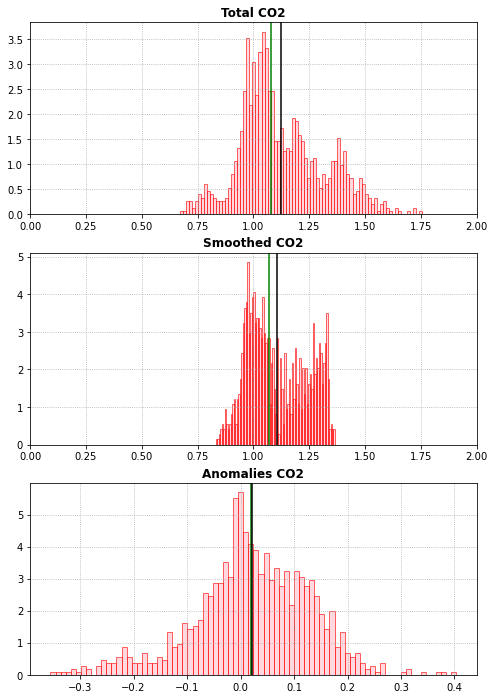

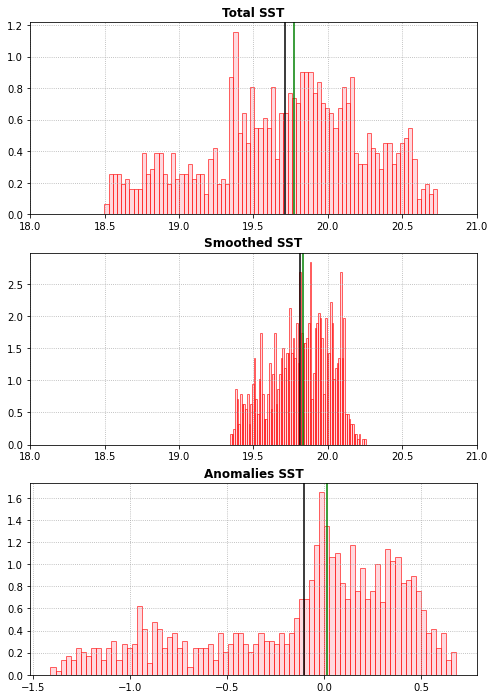

In [32]:
histo_3x3([testvar_o2, res_o2, testano_o2], 'O2', 'medianfilter_o2_pdf.png', [-15,2.5])
histo_3x3([testvar_co2, res_co2, testano_co2], 'CO2', 'medianfilter_co2_pdf.png', [0,2])
histo_3x3([testvar_sst, res_sst, testano_sst], 'SST', 'medianfilter_sst_pdf.png', [18,21])

# over 10 years

In [6]:
ds_original.o2_stf
ds_original.dic_stf

<xarray.DataArray 'dic_stf' (time: 120, yt_ocean: 2700, xt_ocean: 3600)>
[1166400000 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * time      (time) object 0181-01-16 12:00:00 ... 0190-12-16 12:00:00
    geolon_t  (yt_ocean, xt_ocean) float64 -279.9 -279.8 -279.7 ... 80.0 80.0
    geolat_t  (yt_ocean, xt_ocean) float64 -81.11 -81.11 -81.11 ... 65.06 65.02

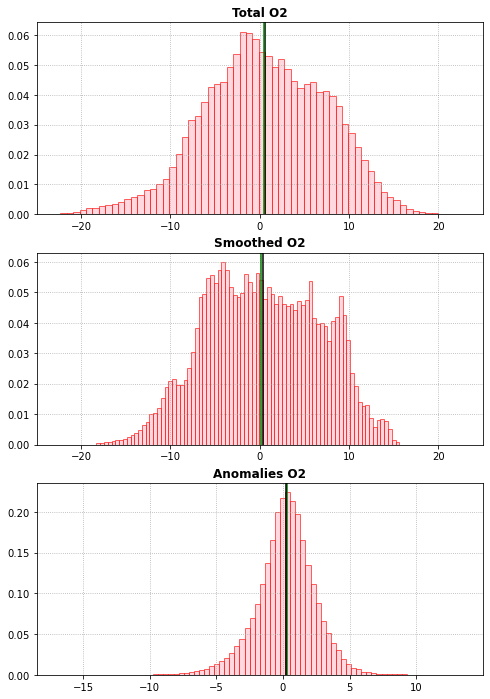

In [14]:
histo_3x3([ds_original.o2_stf, ds_smoothed.o2_stf, dsa.o2_stf], 'O2', 'meanfilter_o2_10y_pdf.png', [-25,25])

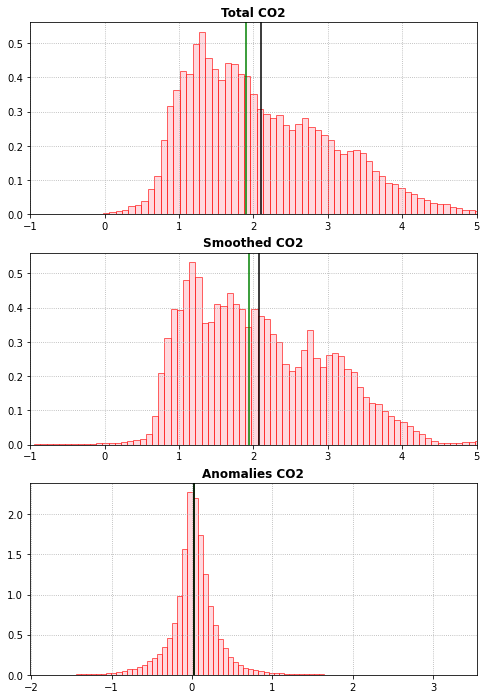

In [15]:
histo_3x3([ds_original.dic_stf, ds_smoothed.dic_stf, dsa.dic_stf], 'CO2', 'meanfilter_co2_10y_pdf.png', [-1,5])

In [7]:
###pick out a small area to test filter with median filter
small_ds=ds_original.sel(xt_ocean=slice(10,30), yt_ocean=slice(-45,-30))

In [13]:
co2=Data_3D_median(small_ds.dic_stf)

In [14]:
o2=Data_3D_median(small_ds.o2_stf)

In [15]:
co2anomed=small_ds.dic_stf-co2
o2anomed=small_ds.o2_stf-o2

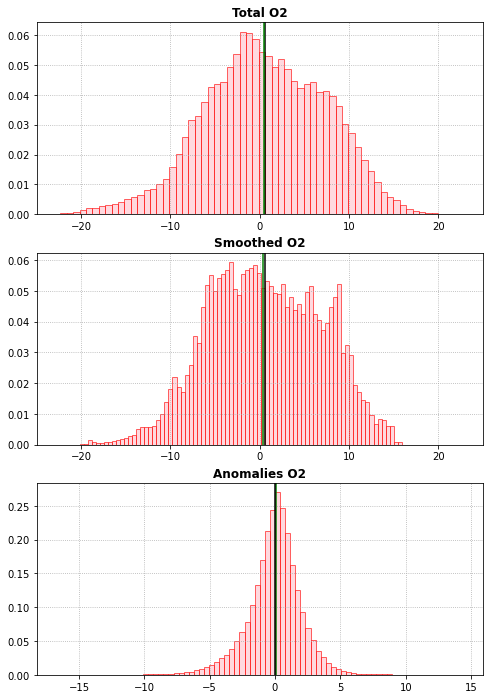

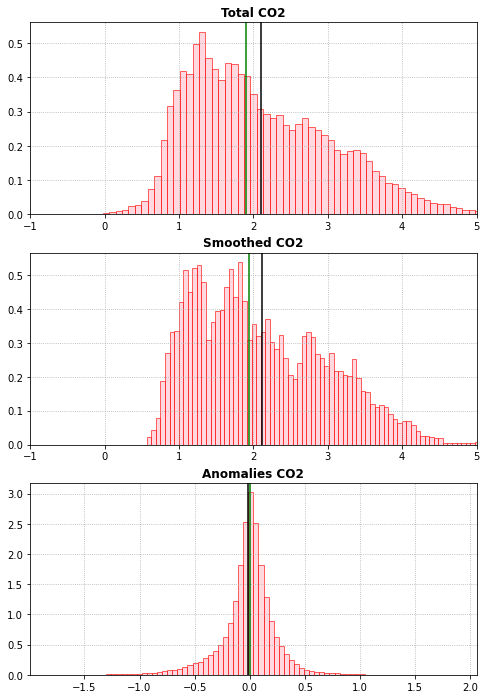

In [19]:
histo_3x3([ds_original.o2_stf, o2, o2anomed], 'O2', 'medianfilter_o2_10y_pdf.png', [-25,25])
histo_3x3([ds_original.dic_stf, co2, co2anomed], 'CO2', 'medianfilter_co2_10y_pdf.png', [-1,5])

# calculate variability of skewness

In [22]:
small_box=ds_original.sel(xt_ocean=slice(15,18), yt_ocean=slice(-38,-35))

In [24]:
mean_co2=small_box.o2_stf.mean(dim=['xt_ocean', 'yt_ocean'])
mean_o2=small_box.dic_stf.mean(dim=['xt_ocean', 'yt_ocean'])
mean_sst=small_box.SST.mean(dim=['xt_ocean', 'yt_ocean'])
median_co2=small_box.o2_stf.median(dim=['xt_ocean', 'yt_ocean'])
median_o2=small_box.dic_stf.median(dim=['xt_ocean', 'yt_ocean'])
median_sst=small_box.SST.median(dim=['xt_ocean', 'yt_ocean'])

In [25]:
###abweichung zwischen mean und median
skew_co2=median_co2-mean_co2
skew_o2=median_o2-mean_o2
skew_sst=median_sst-mean_sst

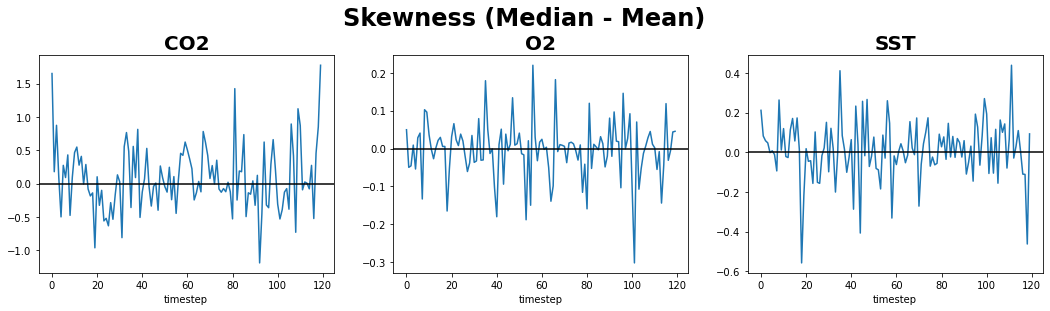

In [49]:
fig, axs=plt.subplots(nrows=1, ncols=3, figsize=(18,4))
axs[0].plot(skew_co2.values)
axs[0].axhline(0, color='black')
axs[0].set_title('CO2', fontweight='bold', fontsize=20)
axs[0].set_xlabel('timestep')

axs[1].plot(skew_o2.values)
axs[1].axhline(0, color='black')
axs[1].set_title('O2', fontweight='bold', fontsize=20)
axs[1].set_xlabel('timestep')


axs[2].plot(skew_sst.values)
axs[2].axhline(0, color='black')
axs[2].set_title('SST', fontweight='bold', fontsize=20)
axs[2].set_xlabel('timestep')


plt.suptitle('Skewness (Median - Mean)', y=1.05, fontsize=24, fontweight='bold')
plt.savefig('/gxfs_home/geomar/smomw577/plots/Boxcar/0181-0190/skewness_timeline.png', dpi=300, bbox_inches='tight')

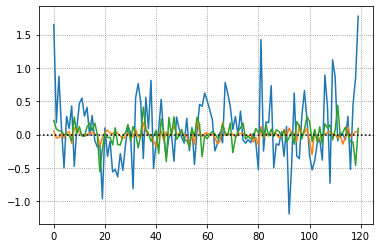

In [53]:
plt.plot(skew_co2.values, label="CO2")
plt.plot(skew_o2.values, label="O2")
plt.plot(skew_sst.values, label="SST")
plt.axhline(0, color='black', linestyle='dotted')
plt.grid(c='gray', linestyle='dotted')

In [55]:
np.corrcoef(skew_co2.values, skew_o2.values)

array([[1.        , 0.17685533],
       [0.17685533, 1.        ]])

In [56]:
np.corrcoef(skew_co2.values, skew_sst.values)

array([[1.        , 0.03775997],
       [0.03775997, 1.        ]])

In [57]:
np.corrcoef(skew_o2.values, skew_sst.values)

array([[1.        , 0.33533915],
       [0.33533915, 1.        ]])